## Compute stacked excess surface density profile arround redMaPPer clusters from the extragalactic cosmoDC2 catalog

This notebook can be run at NERSC or CC-IN2P3 where the DESC DC2 products are stored. You need to be a DESC member to be able to access those. 

In [1]:
import numpy as np
from astropy.table import Table, hstack, vstack
import random
import pickle
from clmm import GalaxyCluster, ClusterEnsemble, GCData
import healpy, glob
import clmm
import matplotlib.pyplot as plt

def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
np.random.seed(1)

### 1. Extract the catalog of redMaPPer clusters detected in the cosmoDC2 extragalactig catalog
- `python extract_cluster_catalog_redMaPPer.py` extract the catalog of redMaPPer-detected clusters
- The output catalog in saved at
-- `/global/cfs/projectdirs/lsst/groups/CL/CLMM/DC2_data/cosmoDC2_v1.1.4_redmapper_v0.8.1_catalog.pkl` (if you use NERSC).
-- `/sps/lsst/groups/clusters/CLMM/DC2_data/cosmoDC2_v1.1.4_redmapper_v0.8.1_catalog.pkl` (if you use NERSC)
- THe figure below displays the redMaPPer catalog

In [2]:
path_DC2_data_ccin2p3 = '/sps/lsst/groups/clusters/CLMM/DC2_data/'
path_DC2_data_nersc = '/global/cfs/projectdirs/lsst/groups/CL/CLMM/DC2_data/'
path_DC2_data = path_DC2_data_ccin2p3

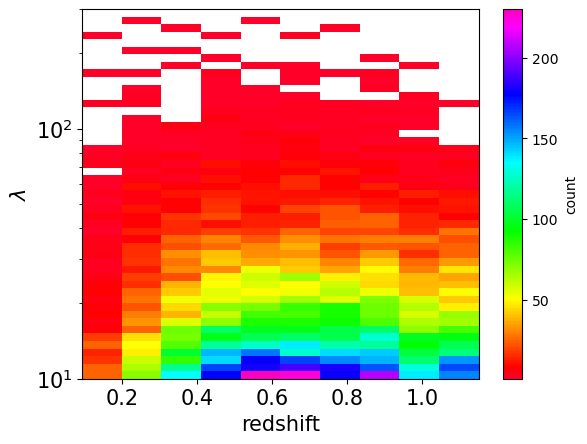

In [3]:
redmapper_cat = load(path_DC2_data + 'cosmoDC2_v1.1.4_redmapper_v0.8.1_catalog.pkl')
plt.hist2d(redmapper_cat['redshift'],redmapper_cat['richness'], cmin=1, bins = [10, np.logspace(np.log10(10), np.log10(300), 50)], cmap = 'gist_rainbow')
plt.colorbar(label='count')
plt.yscale('log')
plt.xlabel('redshift', fontsize=15)
plt.ylabel(r'$\lambda$', fontsize=15)
plt.tick_params(axis="both", which="major", labelsize=15)
plt.show()

### 2. Extract background galaxy sources for a sub-sample of the redMaPPer clusters and estimate individual lensing profiles
- We extract background source catalog for each redMaPPer-detected cluster. We consider a sub-sample of the redMaPPer cluster catalog, wiht richness $20 < \lambda < 40$ and redshift $0.2 < z < 0.4$. This sub-sample consists in $n_{\rm clusters}\sim 450$ clusters. 
- We consider the source selection mag-$i < 24.25$ and mag-$r < 28$, to reach a galaxy density $n_{\rm gal} = 26$ gal/arcmin$^2$. 
- The background galaxies are selected using the simple cut on the true redshift of the source galaxy $z_{s}$, such as $z_{s} > z_{\rm cl}+0.2$. 
- Then, we estimate the lensing profile for each cluster in 15 logarithm equally-spaced radial bins between $0.5$ Mpc and $30$ Mpc. 

#### Extraction of galaxy catalogs from cosmoDC2

- To speed up the extraction of cosmoDC2 source galaxies and lensing profile estimation, we subdivide the cluster sample in 20 independant splits. We then run the extraction for each independent split (containing $\sim 25$ clusters).
- `python extract_sources_and_compute_ind_profile_cosmoDC2_per_split.py --which_split 0 --number_of_splits 30` is an example, which extracts background source catalogs and lensing profiles for clusters in the split with index `0`.
-- The extraction of cosmoDC2 data can be done using GCRCatalogs. Here, we use Qserv available at CC-IN2P3, that provides a fast interface to extract cosmoDC2 quantities (only available at CC-IN2P3). Qserv has design optimized for astronomical queries (parallel distributed SQL database).
-- Some useful functions to deal with cosmoDC2 data are stored in `_utils_cosmoDC2.py`.
-  We then sublmit 20 parrallel jobs for each idependant split. `python jobs_extract_sources_cosmoDC2.py` writes and runs 20 parrallel jobs at CC-IN2P3.
- The individual profiles (stored by split from 0 to 19) are saved in the directory `./DC2_data/individual_redMaPPer_cluster_lensing_profiles/`.
- We group the individual lensing profiles in a single file.

In [4]:
path_to_splits = path_DC2_data + 'individual_redMaPPer_cluster_lensing_profiles/'
list_files = glob.glob(path_to_splits + 'individual_profiles_split*')
for i, name_file in enumerate(list_files):
    file = load(name_file,)
    if i==0: 
        file_stack = file
        continue
    else:
        file_stack = vstack([file_stack, file])

### 3. Creating `ClusterEnsemble object`
- We add the individual lensing profiles to the `ClusterEnsemble object`
- We create three ensemble object, respectively with:
-- clusters within the full range $20 < \lambda < 40$ and $0.2 < z < 0.4$ (450 objects)
-- 100 randomly selected clusters within $20 < \lambda < 40$ and $0.2 < z < 0.4$

In [5]:
#ClusterEnsemble object for the full sample
cluster_ensemble = ClusterEnsemble('stack full sample')
dat = clmm.GCData(
    [file_stack['cluster_id'],
    file_stack['cluster_ra'],
    file_stack['cluster_dec'],
    file_stack['cluster_redshift'],
    file_stack['radius'],
    file_stack['binned_DS_t'],
    file_stack['binned_DS_x'],
    file_stack['W_l'],],
    names=("cluster_id", "ra", "dec", "z", "radius", "DS_t", "DS_x", 'W_l'),
    masked=True,)
cluster_ensemble.data = dat

In [6]:
index_cluster_full = np.arange(len(file_stack))
index_cluster_small = np.random.choice(index_cluster_full, 100, replace=False)
file_stack_small = file_stack[index_cluster_small]

In [7]:
#ClusterEnsemble object for the small sample
cluster_ensemble_small = ClusterEnsemble('stack reduced sample (low-lambda)')
dat = clmm.GCData(
    [file_stack_small['cluster_id'],
    file_stack_small['cluster_ra'],
    file_stack_small['cluster_dec'],
    file_stack_small['cluster_redshift'],
    file_stack_small['radius'],
    file_stack_small['binned_DS_t'],
    file_stack_small['binned_DS_x'],
    file_stack_small['W_l'],],
    names=("cluster_id", "ra", "dec", "z", "radius", "DS_t", "DS_x", 'W_l'),
    masked=True,)
cluster_ensemble_small.data = dat

### 4. Estimating the stacked profile and the covariance matrices
- We compute the stacked lensing profiles for the considered cluster sample. 
- We estimate the stacked profile covariance matrix using three different data-based methods, namely the Sample, the Bootstrap and the Jackknife approaches as detailled in the [example notebook](https://github.com/LSSTDESC/CLMM/blob/main/examples/demo_mock_ensemble.ipynb) of the `ClusterEnsemble object`. Here, we use $N_{\rm side}=16$ and $N_{\rm bootstrap} = 500$.

In [8]:
#stacked profile
cluster_ensemble.make_stacked_radial_profile(tan_component="DS_t", cross_component="DS_x")
r_stack, gt_stack, gx_stack = (cluster_ensemble.stacked_data[c] for c in ("radius", "DS_t", "DS_x"))

cluster_ensemble_small.make_stacked_radial_profile(tan_component="DS_t", cross_component="DS_x")
r_stack_small, gt_stack_small, gx_stack_small = (cluster_ensemble_small.stacked_data[c] for c in ("radius", "DS_t", "DS_x"))

#covariance matrices
cluster_ensemble.compute_sample_covariance(tan_component="DS_t", cross_component="DS_x")
cluster_ensemble.compute_bootstrap_covariance(tan_component="DS_t", cross_component="DS_x", n_bootstrap=500)
cluster_ensemble.compute_jackknife_covariance(n_side=16, tan_component="DS_t", cross_component="DS_x")

cluster_ensemble_small.compute_sample_covariance(tan_component="DS_t", cross_component="DS_x")
cluster_ensemble_small.compute_bootstrap_covariance(tan_component="DS_t", cross_component="DS_x", n_bootstrap=500)
cluster_ensemble_small.compute_jackknife_covariance(n_side=16, tan_component="DS_t", cross_component="DS_x")


err_gt = cluster_ensemble.cov["tan_sc"].diagonal() ** 0.5 / 1e13
err_gx = cluster_ensemble.cov["cross_sc"].diagonal() ** 0.5 / 1e13

err_gt_small = cluster_ensemble_small.cov["tan_sc"].diagonal() ** 0.5 / 1e13
err_gx_small = cluster_ensemble_small.cov["cross_sc"].diagonal() ** 0.5 / 1e13

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


In the Figure below, we plot:
- Upper panel: 
-- the stacked excess surface density profile for the full sample in black, with error-bars coming from the Bootstrap covariance matrix
-- the stacked excess surface density profiles for the small cluster sample
- Lower panel:
-- the same as the upper plot, but considering the cross component of the source galaxy ellipticities.

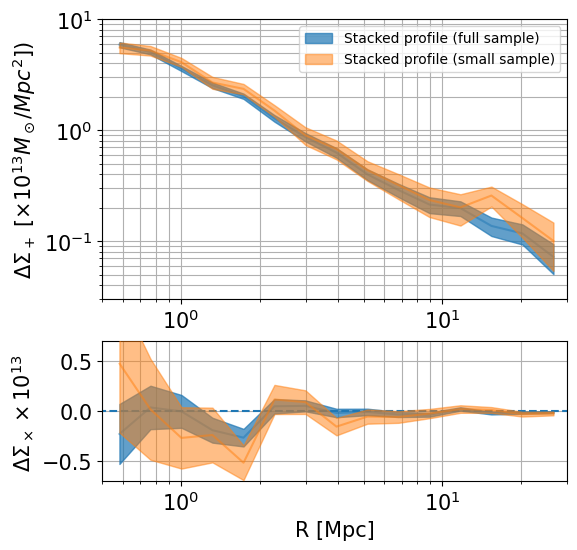

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), gridspec_kw={'height_ratios': [2,1]})

axs[0].fill_between(
    r_stack,
    gt_stack / 1e13 -err_gt,
    gt_stack / 1e13 +err_gt,
    color="C0",
    zorder=100,

    alpha=.7,
    label=r"Stacked profile (full sample)",)
axs[0].plot(
    r_stack,
    gt_stack / 1e13,
    color="C0",
    zorder=100,

    alpha=.5,)

axs[0].fill_between(
    r_stack,
    gt_stack_small / 1e13 -err_gt_small,
    gt_stack_small / 1e13 +err_gt_small,
    color="C1",
    zorder=100,

    alpha=.5,
    label=r"Stacked profile (small sample)",)
axs[0].plot(
    r_stack_small,
    gt_stack_small / 1e13,
    color="C1",
    zorder=100,

    alpha=.5,)

# for i in range(400):
#      axs[0].plot(
#          cluster_ensemble.data["radius"][i],
#          cluster_ensemble.data["DS_t"][i] / 1e13,
#          "C1",
#          alpha=.1,
#          linewidth=1,)
#      axs[1].plot(
#          cluster_ensemble.data["radius"][i],
#          cluster_ensemble.data["DS_x"][i] / 1e13,
#          "C1",
#          alpha=.1,
#          linewidth=1,)
    
axs[0].loglog([], [], )

axs[1].fill_between(
    r_stack,
    gx_stack / 1e13 -err_gx,
    gx_stack / 1e13 +err_gx,
    color="C0",
    zorder=100,

    alpha=.7,
    label=r"Stacked profile (full sample)",)
axs[1].plot(
    r_stack,
    gx_stack / 1e13,
    color="C0",
    zorder=100,

    alpha=.5,)

axs[1].fill_between(
    r_stack,
    gx_stack_small / 1e13 -err_gx_small,
    gx_stack_small / 1e13 +err_gx_small,
    color="C1",
    zorder=100,

    alpha=.5,
    label=r"Stacked profile (small sample)",)
axs[1].plot(
    r_stack_small,
    gx_stack_small / 1e13,
    color="C1",
    zorder=100,

    alpha=.5,)
x = np.linspace(-10, 50, 100)
axs[1].plot(x, 0*x, '--')
axs[1].set_xscale('log')
axs[0].set_xscale('log')
axs[1].set_xlabel("R [Mpc]", fontsize=15)
axs[0].tick_params(axis="both", which="major", labelsize=15)
axs[1].tick_params(axis="both", which="major", labelsize=15)
axs[0].set_ylabel(r"$\Delta\Sigma_+$ $[\times 10^{13} M_\odot /Mpc^2])$", fontsize=15)
axs[1].set_ylabel(r"$\Delta\Sigma_\times \times 10^{13}$ ", fontsize=15)
axs[0].grid(True, which='both')
axs[1].grid(True, which='both')
axs[0].set_ylim(0.03, 10)
axs[1].set_ylim(-0.7, 0.7)
axs[0].set_xlim(0.5, 30)
axs[1].set_xlim(0.5, 30)
axs[0].legend()
plt.savefig(f'redmapper_clusters_lensing_stacked_profile_DC2.png', bbox_inches='tight', dpi=200)

In the Figure below, we plot the diagonal elements of the three covariance matrices, estimated respectively using the sample, bootstrap and Jackknife approach.

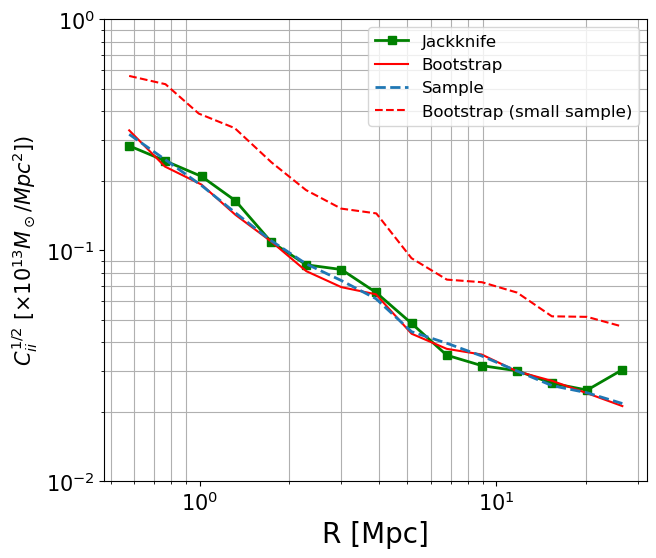

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(
    cluster_ensemble.data["radius"][0],
    (cluster_ensemble.cov["tan_jk"].diagonal() ** 0.5)/1e13  ,'-s',
    label="Jackknife",
    color='g',
    linewidth=2,
)

plt.plot(
    cluster_ensemble.data["radius"][0],
    (cluster_ensemble.cov["tan_bs"].diagonal() ** 0.5)/1e13  ,
    "-",color = 'r',
    label="Bootstrap",
    linewidth=1.5,
    markersize=4,
)
plt.plot(
    cluster_ensemble.data["radius"][0],
    (cluster_ensemble.cov["tan_sc"].diagonal() ** 0.5) /1e13  ,
    "--",color='C0',
    label="Sample",
    linewidth=2,
)
plt.loglog(
    cluster_ensemble_small.data["radius"][0],
    (cluster_ensemble_small.cov["tan_bs"].diagonal() ** 0.5)/1e13 ,
    "--",
    c="r",
    label="Bootstrap (small sample)",
    linewidth=1.5,
    markersize=4,
)
plt.xlabel("R [Mpc]", fontsize=20)
plt.ylabel(r"$C_{ii}^{1/2}$ $[\times 10^{13} M_\odot /Mpc^2])$", fontsize=15)
plt.tick_params(axis="both", which="major", labelsize=15)
plt.legend(frameon=True, fontsize=12)
plt.minorticks_on()
plt.grid(lw=0.5)
plt.ylim(0.01, 1)
plt.grid(which="both",)
plt.xscale('log')
plt.savefig(f'redmapper_clusters_lensing_stacked_profile_DC2_variance.png', bbox_inches='tight', dpi=200)

Similarly, we show the associated correlation matrices.

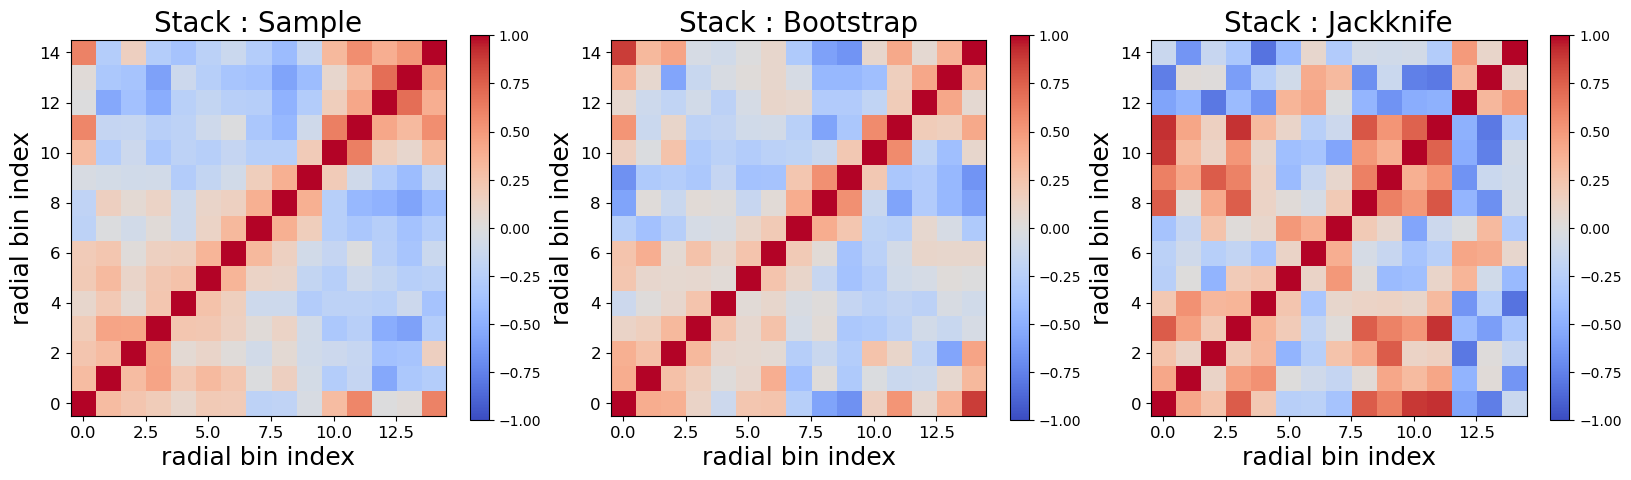

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.subplots_adjust(wspace=0.15, hspace=0)

maximum = cluster_ensemble.cov["tan_sc"].max()
for ax, cov, label in zip(
    axes,
    [cluster_ensemble.cov["tan_sc"], cluster_ensemble.cov["tan_bs"], cluster_ensemble.cov["tan_jk"]],
    ["Stack : Sample", "Stack : Bootstrap", "Stack : Jackknife"],
):
    ax.set_title(label, fontsize=20)
    ax.set_xlabel("radial bin index", fontsize=18)
    ax.set_ylabel("radial bin index", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=12)
    im = ax.imshow(np.corrcoef(cov), cmap="coolwarm", vmin=-1, vmax=1, origin="lower")
    plt.colorbar(im, ax=ax)
plt.show()

(to save just one figure)

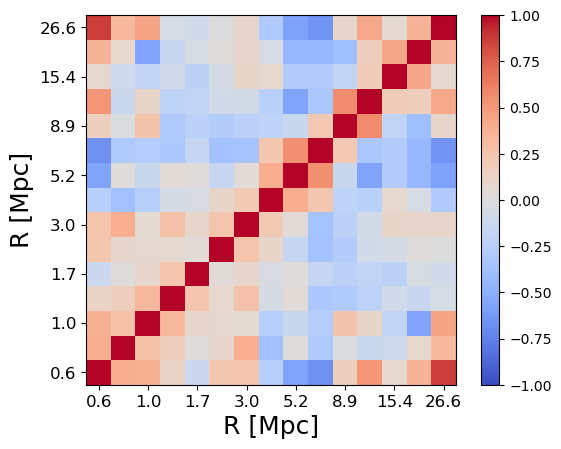

In [12]:
plt.xlabel("R [Mpc]", fontsize=18)
plt.ylabel("R [Mpc]", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=12)
im = plt.imshow(np.corrcoef(cluster_ensemble.cov["tan_bs"]), cmap="coolwarm", vmin=-1, vmax=1, origin="lower")
ticks = np.array([0, 2, 4, 6, 8, 10, 12, 14])
labels = [f'{r_stack[t]:.1f}' for t in ticks]
plt.xticks(labels = labels, ticks=ticks, )
plt.yticks(labels = labels, ticks=ticks, )

plt.colorbar()
plt.savefig(f'redmapper_clusters_lensing_stacked_profile_DC2_correlation_matrix.png', bbox_inches='tight', dpi=200)
plt.show()